In [1]:
import sys
import os

# Adjust the path to point to your project root.
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from modules import Bloch, Model, K_mesh, Wannier
from modules.bloch import finite_diff_coeffs, levi_civita
from example.models import fu_kane_mele
# from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from itertools import product, permutations
from scipy.integrate import cumulative_simpson
from math import factorial
import tensorflow as tf
from scipy.linalg import polar

%load_ext line_profiler
%timeit

In [3]:
# from pythtb import *
# from wanpy.wpythtb import *
# from scipy.linalg import eigh
from tensorflow import constant as const
import tensorflow.linalg as tfla
from tensorflow import complex64

In [4]:
def fin_diff(U_k, mu, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

    fd_sum = np.zeros_like(U_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(U_k, shift=-s, axis=mu)

    v = fd_sum / (dk_mu)
    return v


def berry_curvature(v_k, H_flat, occ_idxs=None, batched=False):
    # tensorflow optimization
    H_flat_tf = const(H_flat, dtype=complex64)
    v_k_tf = const(v_k, dtype=complex64)

    evals_tf, evecs_tf = tfla.eigh(H_flat_tf)

    # swap for consistent indexing
    evecs_tf = tf.transpose(evecs_tf, perm=[0, 1, 3, 2])  # (n_kpts, n_beta, n_state, n_state)
    evecs_T_tf = tf.transpose(evecs_tf, perm=[0, 1, 3, 2])  # (n_kpts, n_beta, n_state, n_state)

    evecs_conj_tf = tf.math.conj(evecs_tf)

    # Rotate velocity operators to eigenbasis
    v_k_rot_tf = tf.matmul(
        evecs_conj_tf[None, :, :, :, :],  # (1, n_kpts, n_beta, n_state, n_state)
        tf.matmul(
            v_k_tf,                       # (dim_k, n_kpts, n_beta, n_state, n_state)
            evecs_T_tf[None, :, :, :, :]  # (1, n_kpts, n_beta, n_state, n_state)
        )
    )  # (dim_k, n_kpts, n_beta, n_state, n_state)

    # Identify occupied bands
    n_eigs = evals_tf.shape[-1]
    if occ_idxs is None:
        occ_idxs =  np.arange(n_eigs//2)
    elif occ_idxs == 'all':
        occ_idxs =  np.arange(n_eigs)
    else:
        occ_idxs = np.array(occ_idxs)

    # Identify conduction bands
    cond_idxs = np.setdiff1d(np.arange(n_eigs), occ_idxs)  # Identify conduction bands

    # Compute energy denominators
    delta_E_tf = evals_tf[..., None, :] - evals_tf[..., :, None]
    delta_E_occ_cond_tf = tf.gather(tf.gather(delta_E_tf, occ_idxs, axis=-2), cond_idxs, axis=-1)
    delta_E_cond_occ_tf = tf.gather(tf.gather(delta_E_tf, cond_idxs, axis=-2), occ_idxs, axis=-1)
    inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond_tf
    inv_delta_E_cond_occ_tf = 1 / delta_E_cond_occ_tf

    v_occ_cond_tf = tf.gather(tf.gather(v_k_rot_tf, occ_idxs, axis=-2), cond_idxs, axis=-1)
    v_cond_occ_tf = tf.gather(tf.gather(v_k_rot_tf, cond_idxs, axis=-2), occ_idxs, axis=-1)
    v_occ_cond_tf = v_occ_cond_tf * inv_delta_E_occ_cond_tf
    v_cond_occ_tf = v_cond_occ_tf * -inv_delta_E_cond_occ_tf

    # Compute Berry curvature
    b_curv_tf = 1j * (
        tf.matmul(v_occ_cond_tf[:, None], v_cond_occ_tf[None, :]) -
        tf.matmul(v_occ_cond_tf[None, :], v_cond_occ_tf[:, None])
    )

    # # Convert final result to NumPy
    b_curv = b_curv_tf.numpy()

    return b_curv

In [5]:
########## Model #############

# Reference Model
t = 1     # spin-independent first-neighbor hop
soc = 1/4   # spin-dependent second-neighbor hop
m = 1/2     # magnetic field magnitude
beta = np.pi/4  # Adiabatic parameter
fkm_model = fu_kane_mele(t, soc, m, beta)

# Model generator for a set of fixed parameters
fixed_params = {"t": 1.0, "soc": 1/4, "m": 1/2}
model_gen = partial(fu_kane_mele, **fixed_params)

### Adiabatic parameters
# k space
nks = 40, 40, 40
k_flat = np.array(list(product(*[np.linspace(0, 1, nk, endpoint=False) for nk in nks])))

# lambda space
n_beta = 100
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=False) # change to endpoint=False for periodic
lambda_vals = {"beta": betas}

########### Useful model information ###########
recip_lat_vecs = fkm_model.get_recip_lat_vecs()  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.n_spin   # Number of spins
n_orb = fkm_model.n_orb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions (1)
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_spin}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))


Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2
(nks, nbeta): (40, 40, 40, 100)
Total number of parameter points: 6400000


In [6]:
fkm_model.visualize_3d()

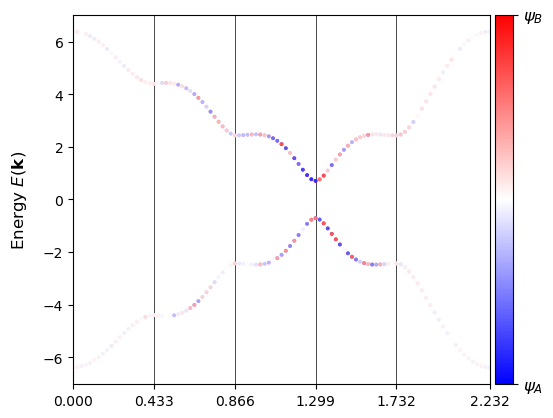

(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

In [7]:
k_path = [[0,0,0], [1/2,0,0], [1/2, 1/2, 0], [1/2,1/2,1/2], [1/2, 0, 1/2], [0,0,0]]

fkm_model.plot_bands(k_path, show=True, proj_orb_idx=[0])

In [8]:
# Generating k-space mesh
k_vals = [np.arange(nk) / nk for nk in nks] # exlcudes endpoint

sq_mesh = np.meshgrid(*k_vals, indexing='ij')
flat_mesh = np.stack(sq_mesh, axis=-1).reshape(-1, len(nks)) # 1D list of k-vectors
square_mesh = flat_mesh.reshape(*[nk for nk in nks], len(nks)) # each index is a direction in k-space

In [9]:
####### kappa (q) internal differentials ########
dq = np.zeros((dim_total, dim_total)) 
np.fill_diagonal(dq[:dim_k, :dim_k], 1 / np.array(nks))
np.fill_diagonal(dq[dim_k:, dim_k:], 1 / np.array(n_beta))
d4q = np.linalg.det(dq)

print("Metric in reduced coordinates: \n", dq)
print(f"d^4q = {d4q}")

Metric in reduced coordinates: 
 [[0.025 0.    0.    0.   ]
 [0.    0.025 0.    0.   ]
 [0.    0.    0.025 0.   ]
 [0.    0.    0.    0.01 ]]
d^4q = 1.5625000000000017e-07


# Kubo

In [10]:
# Getting the Hamiltonian and velocity operator at each point in k-space and beta-space
v_k = np.zeros((fkm_model.dim_k, k_flat.shape[0], n_beta, n_states, n_states), dtype=complex)
H_kbeta = np.zeros((k_flat.shape[0], n_beta, n_states, n_states), dtype=complex)

for idx, beta in enumerate(betas):
    print(idx)
    fkm_model_fxd = model_gen(beta=beta)

    H = fkm_model_fxd.get_ham(k_flat)
    v = fkm_model_fxd.get_velocity(k_flat)

    # flatten spin
    new_shape = (H.shape[0],) + (n_spin*n_orb, n_spin*n_orb)
    H = H.reshape(*new_shape) 
    new_shape = (v.shape[:2]) + (n_spin*n_orb, n_spin*n_orb)
    v = v.reshape(*new_shape)
    
    H_kbeta[:, idx, ...] = H
    v_k[:, :, idx, ...] = v

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [11]:
# Getting velocity from finite differences for beta direction
v_beta = fin_diff(H_kbeta, mu=1, dk_mu=np.linalg.norm(dq[-1]), order_eps=9)

# Concatenating as a new dimension to the velocity operator over k-space
v = np.concatenate((v_k, v_beta[np.newaxis, ...]), axis=0)

In [12]:
# Getting Berry curvature from Kubo formula (using velocity operator)
b_curv_kubo = berry_curvature(v, H_kbeta)

2025-04-22 02:52:16.165066: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-22 02:52:16.170868: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-22 02:52:16.171134: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-22 02:52:16.171302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 02:52:16.171617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
epsilon = levi_civita(4, 4)
chern2_density_kubo = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv_kubo, b_curv_kubo)

In [14]:
C2_kubo = np.sum(chern2_density_kubo) * (d4q) / (32 * np.pi**2)
print("C2 from Kubo: ", C2_kubo.real)

C2 from Kubo:  1.00010245779002


In [15]:
dtheta = np.sum(chern2_density_kubo, axis=(0)) 
thetas_kubo = np.cumsum(dtheta) * d4q / (16 * np.pi)

Text(0.5, 1.0, 'number of parameters: (40, 40, 40, 100)')

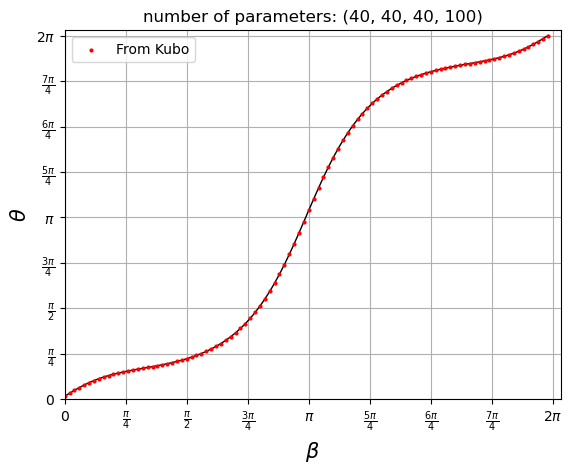

In [16]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

### Riemann sum
ax.plot(betas, thetas_kubo.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_kubo.real, s=4, zorder=2, c='r', label='From Kubo')

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.set_ylim(0, 2*np.pi+0.1)
ax.set_xlim(0, 2*np.pi+0.1) 

# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

ax.grid()
ax.legend()
ax.set_title(f"number of parameters: {n_param}")

# Berry connections

In [17]:
import sys
import os

# Adjust the path to point to your project root.
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [18]:
from modules import Bloch, Model, K_mesh, Wannier
from modules.bloch import finite_diff_coeffs, levi_civita
from example.models import fu_kane_mele
# from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from itertools import product, permutations
from scipy.integrate import cumulative_simpson
from math import factorial
# import tensorflow as tf
from scipy.linalg import polar

%load_ext line_profiler
%timeit

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [19]:
import torch

In [20]:
# Fu-Kane-Mele Model
t = 1            # spin-independent first-neighbor hop
soc = 1/4        # spin-dependent second-neighbor hop
m = 1/2          # magnetic field magnitude
beta = np.pi/4   # Adiabatic parameter
model = fu_kane_mele(t, soc, m, beta)

n_spin = model.n_spin   # Number of spins
n_orb = model.n_orb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

In [21]:
# Energy eigenstates
nks = 50, 50, 50
bloch_states = Bloch(model, *nks)
# bloch_states.solve_model()

In [22]:
flat_mesh = bloch_states.k_mesh.flat_mesh
sq_mesh = bloch_states.k_mesh.square_mesh

In [23]:
bloch_states.set_Bloch_ham()

H_k = bloch_states.H_k
H_k = H_k.reshape(-1, n_orb, n_spin, n_orb, n_spin)

In [24]:
# shape(ham): (Nk, n_orb, n_orb), (Nk, n_orb, n_spin, n_orb, n_spin)
# or in finite cases (n_orb, n_orb), (n_orb, n_spin, n_orb, n_spin)

# flatten spin axes
if H_k.ndim == 2 * model._nspin + 1:
    # have k points
    new_shape = (H_k.shape[0],) + (
        model._nspin * model._norb,
        model._nspin * model._norb,
    )
    if model._nspin == 1:
        shape_evecs = (H_k.shape[0],) + (model._norb, model._norb)
    elif model._nspin == 2:
        shape_evecs = (H_k.shape[0],) + (
            model._nspin * model._norb,
            model._norb,
            model._nspin,
        )
elif H_k.ndim == 2 * model._nspin:
    # must be a finite sample, no k-points
    new_shape = (model._nspin * model._norb, model._nspin * model._norb)
    if model._nspin == 1:
        shape_evecs = (model._norb, model._norb)
    elif model._nspin == 2:
        shape_evecs = (model._nspin * model._norb, model._norb, model._nspin)
else:
    raise ValueError("Hamiltonian has wrong shape.")

ham_use = H_k.reshape(*new_shape)

if not np.allclose(ham_use, ham_use.swapaxes(-1, -2).conj()):
    raise Exception("Hamiltonian matrix is not hermitian")

In [25]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

ham_torch = torch.from_numpy(ham_use)
eval, evec = torch.linalg.eigh(ham_torch)
eval = eval.numpy()
evec = evec.numpy()
evec = evec.swapaxes(-1, -2)
evec = evec.reshape(*shape_evecs)

eigvecs = evec.reshape(*bloch_states.k_mesh.nks, *evec.shape[1:])
eigvals = eval.reshape(*bloch_states.k_mesh.nks, *eval.shape[1:])

In [26]:
bloch_states.energies = eigvals
bloch_states.set_wfs(eigvecs, spin_flattened=False, set_projectors=False)
bloch_states.is_energy_eigstate = True

In [27]:
# velocity operator
v_k = model.get_velocity(flat_mesh)
print(v_k.shape)
# axes for each k-dimension, flatten spin
v_k = v_k.reshape(model.dim_r, *nks, model.n_spin * model.n_orb, model.n_spin * model.n_orb)
print(v_k.shape)

(3, 125000, 2, 2, 2, 2)
(3, 50, 50, 50, 4, 4)


In [28]:
u_nk = bloch_states.get_states()["Cell periodic"]
psi_nk = bloch_states.get_states()["Bloch"]
u_nk_flat = bloch_states.get_states(flatten_spin=True)["Cell periodic"]
psi_nk_flat = bloch_states.get_states(flatten_spin=True)["Bloch"]
E_nk = bloch_states.energies

n_occ = bloch_states._n_states//2

print(bloch_states.get_wf_axes())
print("Number of states:", bloch_states._n_states)
print("Number of occupied bands:", n_occ)
print("Number of conduction bands:", bloch_states._n_states - n_occ)

{'wf shape': (50, 50, 50, 4, 2, 2), 'Number of axes': 6, 'k-axes': (0, 1, 2), 'lambda-axes': (), 'spin-axis': -1, 'orbital axis': -2, 'state axis': -3}
Number of states: 4
Number of occupied bands: 2
Number of conduction bands: 2


In [29]:
# Getting occupied and conduction states and energies
u_occ, psi_occ = u_nk[..., :n_occ, :, :], psi_nk[..., :n_occ, :, :]
u_con, psi_con = u_nk[..., n_occ:, :, :], psi_nk[..., n_occ:, :, :]
E_occ, E_con = E_nk[..., :n_occ], E_nk[..., n_occ:]

# Bloch class for occupied bands
bloch_occ = Bloch(model, *nks)
bloch_occ.set_wfs(u_occ, cell_periodic=True, set_projectors=False)

# Bloch class for conduction bands
bloch_con = Bloch(model, *nks)
bloch_con.set_wfs(u_con, cell_periodic=True, set_projectors=False)

u_occ_flat = bloch_occ.get_states(flatten_spin=True)["Cell periodic"]
psi_occ_flat = bloch_occ.get_states(flatten_spin=True)["Bloch"]
u_con_flat = bloch_con.get_states(flatten_spin=True)["Cell periodic"]
psi_con_flat = bloch_con.get_states(flatten_spin=True)["Bloch"]

# Projection gauge

In [30]:
# Just for getting trial wavefunctions
WF = Wannier(model, bloch_states, *nks)

# For tilde (projection) gauge states
bloch_tilde = WF.tilde_states

# k-space mesh
mesh = K_mesh(model, *nks)

### Trial Wavefunctions
- anti-bonding combination spin up/down on two sites in primitve cell

In [31]:
# (orbital, spin, amp)
tf_list = [ [(0, 0, 1), (1, 0, -1) ], [(0, 1, 1), (1, 1, -1) ]]
# twf1 = [(0, 0, 1), (1, 0, -1), (0, 1, 1), (1, 1, -1) ]
# twf2 = [(0, 0, 1), (1, 0, 1), (0, 1, 1), (1, 1, 1) ]
# tf_list = [ twf1, twf2]

n_tfs = len(tf_list)
twfs = WF.get_trial_wfs(tf_list)

twfs

array([[[ 0.70710678+0.j,  0.        +0.j],
        [-0.70710678+0.j,  0.        +0.j]],

       [[ 0.        +0.j,  0.70710678+0.j],
        [ 0.        +0.j, -0.70710678+0.j]]])

### Overlap matrix

In [32]:
# Get flattened trial wfs
twfs_flat = twfs.reshape((*twfs.shape[:1], -1))

print("Trial wfs shape:", twfs_flat.shape)
print("Occupied wfs shape:", psi_occ_flat.shape)
print("Conduction wfs shape:", psi_con_flat.shape)

Trial wfs shape: (2, 4)
Occupied wfs shape: (50, 50, 50, 2, 4)
Conduction wfs shape: (50, 50, 50, 2, 4)


In [33]:
# Overlap matrix S_nm = <psi_nk| g_m> with occupied bands
S_occ = np.einsum("...nj, mj -> ...nm", psi_occ_flat.conj(), twfs_flat)

# Overlap matrix S_nm = <psi_nk| g_m> with conduction bands
S_con = np.einsum("...nj, mj -> ...nm", psi_con_flat.conj(), twfs_flat)

print("S_occ shape:", S_occ.shape)
print("S_con shape:", S_con.shape)

S_occ shape: (50, 50, 50, 2, 2)
S_con shape: (50, 50, 50, 2, 2)


In [36]:
bloch_states.k_mesh.idx_arr.shape

(125000, 3)

In [ ]:
### SVD
W, D, Vh = np.linalg.svd(S_occ, full_matrices=True)
D_mat = np.einsum("...i, ij -> ...ij", D, np.eye(D.shape[-1])) # Make a diagonal matrix
# Unitary part
U_SVD = W @ Vh

### Polar decomposition

# polar must be applied to a square matrix, doesn't vectorize along k
pol = np.array([polar(S_occ[k]) for k in bloch_states.k_mesh.idx_arr])
U_pol = pol[:, 0]
P = pol[:, 1]

# reshape along k-dimension, since polar doesn't vectorize
U_pol = U_pol.reshape(*u_occ.shape[:3], *U_pol.shape[1:])
P = P.reshape(*u_occ.shape[:3], *P.shape[1:])

# Check that the unitaries are the same for polar and SVD
np.allclose(U_pol, U_SVD)

ValueError: `a` must be a 2-D array.

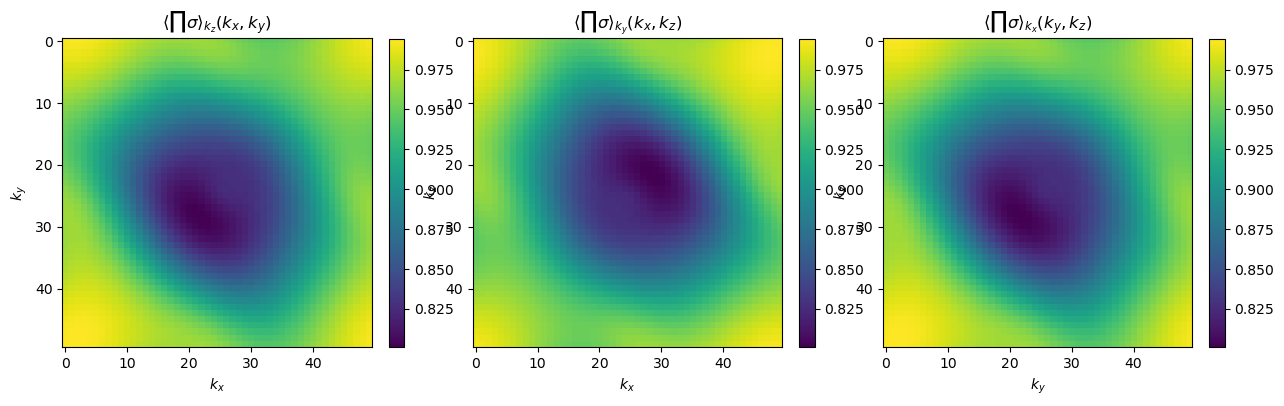

In [ ]:
# Plotting average singular values on planes
prodD = np.prod(D, axis=-1)
sigma_kxky_avg = np.sum(prodD, axis=2) / D.shape[2]
sigma_kxkz_avg = np.sum(prodD, axis=1) / D.shape[1]
sigma_kykz_avg = np.sum(prodD, axis=0) / D.shape[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im1 = ax[0].imshow(sigma_kxky_avg.real)
ax[0].set_title(r"$\langle \prod \sigma \rangle_{k_z}(k_x, k_y)$")
ax[0].set_xlabel(r"$k_x$")
ax[0].set_ylabel(r"$k_y$")

im2 = ax[1].imshow(sigma_kxkz_avg.real)
ax[1].set_title(r"$\langle \prod \sigma \rangle_{k_y}(k_x, k_z)$")
ax[1].set_xlabel(r"$k_x$")
ax[1].set_ylabel(r"$k_z$")

im3 = ax[2].imshow(sigma_kykz_avg.real)
ax[2].set_title(r"$\langle \prod \sigma \rangle_{k_x}(k_y, k_z)$")
ax[2].set_xlabel(r"$k_y$")
ax[2].set_ylabel(r"$k_z$")

cb = plt.colorbar(im1, fraction=0.045)
cb = plt.colorbar(im2, fraction=0.045)
cb = plt.colorbar(im3, fraction=0.045)


In [ ]:
# Use unitary to rotate occupied bands into tilde basis for smooth gauge
psi_tilde = np.einsum("...mn, ...mj -> ...nj", U_SVD, psi_occ_flat) # shape: (*nks, states, orbs*n_spin])

bloch_tilde.set_wfs(psi_tilde, cell_periodic=False, spin_flattened=True, set_projectors=False)
u_tilde_flat = bloch_tilde.get_states(flatten_spin=True)["Cell periodic"]
print("Shape of tilde{u_nk} array:", u_tilde_flat.shape)

Shape of tilde{u_nk} array: (50, 50, 50, 2, 4)


### Get Berry flux in projection gauge

In [ ]:
# Using plaquettes to get Berry curvatures and flux in projection gauge
Omega_tilde, Omega_flux_tilde = bloch_tilde.berry_curv(non_abelian=True, state_idx=[0,1], return_flux=True)

Computing flux in plane: mu=0, nu=1
Computing flux in plane: mu=0, nu=2
Computing flux in plane: mu=1, nu=2


In [ ]:
# Using plaquettes to get Berry curvatures and flux in Hamiltonian gauge
Omega, Omega_flux = bloch_occ.berry_curv(non_abelian=True, state_idx=[0,1], return_flux=True)

Computing flux in plane: mu=0, nu=1
Computing flux in plane: mu=0, nu=2
Computing flux in plane: mu=1, nu=2


In [ ]:
omega_kubo = fkm_model.berry_curvature(flat_mesh, abelian=False)
omega_kubo = omega_kubo.reshape(*omega_kubo.shape[:2], *nks, *omega_kubo.shape[3:])

(125000, 4, 4)


In [242]:
# Make sure gauge covariance is satisfied
print("Gauge covariant?", np.allclose(Omega, U_SVD @ Omega_tilde @ np.swapaxes(U_SVD.conj(), -1,-2)))

Gauge covariant? True


In [243]:
omega_kubo[0,1][0,4,0]

array([[-0.00464359+0.00000000e+00j,  0.02567969-3.10171586e-02j],
       [ 0.02567969+3.10171586e-02j,  0.00464359+2.77555756e-17j]])

In [244]:
Omega[0,1][0,4,0]

array([[ 0.00017704+1.23574118e-14j,  0.00083103+9.24344862e-04j],
       [ 0.00083103-9.24344862e-04j, -0.00017704-1.23575108e-14j]])

In [245]:
diff = omega_kubo - Omega_flux*nks[0]*nks[1]
np.amax(diff)

np.complex128(196.44538944852877+17.335928522607823j)

### Get Berry connection from U links

$U$ links found from 
$$M_{nm}^{(k, \mu)} = \langle u_{nk}| u_{m,k+\delta k_\mu} \rangle$$
$$M = V \Sigma W^{\dagger} \rightarrow U^{(k, \mu)} = WV^{\dagger}$$

Berry connection is 

$$A_{\mu} = -i \text{log} U / \delta k_{\mu}$$

In [246]:
U_links_tilde = bloch_tilde.get_links(None)
U_links_occ = bloch_occ.get_links(None)

dks = [1/nk for nk in nks]

In [247]:
eigvals, eigvecs = np.linalg.eig(U_links_tilde)
angles = -np.angle(eigvals)
angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1]))
eigvecs_inv = np.linalg.inv(eigvecs)
# Berry connection for tilde states
berry_conn_tilde = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv)
# divide by dk (reduced coordinates) 
berry_conn_tilde /= np.array(dks)[:, None, None, None, None, None]

eigvals, eigvecs = np.linalg.eig(U_links_occ)
angles = -np.angle(eigvals)
angles_diag = np.einsum("...i, ij -> ...ij", angles, np.eye(angles.shape[-1])) 
eigvecs_inv = np.linalg.inv(eigvecs)
# Getting the Berry connection from the Bloch states
berry_conn_occ = np.matmul(np.matmul(eigvecs, angles_diag), eigvecs_inv)
# divide by dk (reduced coordinates)
berry_conn_occ /= np.array(dks)[:, None, None, None, None, None]

print("A_mu Hermitian?", np.allclose(berry_conn_occ[2], berry_conn_occ[2].conj().swapaxes(-1,-2)))
print("tilde{A}_mu Hermitian?", np.allclose(berry_conn_occ[2], berry_conn_occ[2].conj().swapaxes(-1,-2)))

A_mu Hermitian? True
tilde{A}_mu Hermitian? True


In [248]:
berry_conn_tilde[1,0,10,0].round(5)

array([[0.82971-0.j     , 0.04431-0.04431j],
       [0.04431+0.04431j, 0.74109+0.j     ]])

# Now computing axion angle $\theta$

In [249]:
Omega_tilde[0,1][0,2,0].round(5)

array([[-0.00014+0.j     , -0.00023+0.00023j],
       [-0.00023-0.00023j,  0.00014-0.j     ]])

Using

$ \theta = -\frac{1}{4\pi} \int d^3k \epsilon_{ijk} \text{Tr} \left[  A_i \partial_j A_k - \frac{2i}{3} A_i A_j A_k \right]$


In [250]:
parx_A = fin_diff(berry_conn_tilde, mu=1, dk_mu=dks[0], order_eps=15, mode='central')
pary_A = fin_diff(berry_conn_tilde, mu=2, dk_mu=dks[1], order_eps=15, mode='central')
parz_A = fin_diff(berry_conn_tilde, mu=3, dk_mu=dks[2], order_eps=15, mode='central')
par_A = np.array([parx_A, pary_A, parz_A])

In [251]:
epsilon = levi_civita(3,3)
AdA = np.einsum("i...ab, jk...ba -> ijk...", berry_conn_tilde, par_A)
AAA = np.einsum("i...ab, j...bc, k...ca -> ijk...", berry_conn_tilde, berry_conn_tilde, berry_conn_tilde)
integrand = np.einsum("ijk, ijk... -> ...", epsilon, AdA - (2j/3) * AAA)
# integrand = np.einsum("ijk, ijk... -> ...", epsilon, AdA)

theta = -(4*np.pi)**(-1) * np.sum(integrand) * np.prod(dks)
theta

np.complex128(0.44174253069635877+3.5620016828128865e-18j)

In [252]:
omega_tilde = U_SVD @ omega_kubo @ np.swapaxes(U_SVD.conj(), -1,-2)

In [253]:
np.amax(np.einsum("ijk, i...ab, j...bc, k...ca -> ...", epsilon, berry_conn_tilde, berry_conn_tilde, berry_conn_tilde))

np.complex128(1.7534862450929722e-12+451.65003977985066j)

In [254]:
brackets = np.einsum("ijk, i...nm, jk...mn -> ...", epsilon, berry_conn_tilde, omega_tilde)
brackets += (1j/3) * np.einsum("ijk, i...ab, j...bc, k...ca -> ...", epsilon, berry_conn_tilde, berry_conn_tilde, berry_conn_tilde)

theta = -(4*np.pi)**(-1) * np.sum(brackets) * (1/np.prod(nks))
theta

np.complex128(0.0738643221032644+4.155183583223496e-17j)

In [255]:
np.amax(berry_conn_tilde[0]@berry_conn_tilde[1] - berry_conn_tilde[1]@berry_conn_tilde[0])

np.complex128(21.71671372494079-2.506311471519912j)

In [256]:
(parx_A[1] - pary_A[0] - 1j* (berry_conn_tilde[0]@berry_conn_tilde[1] - berry_conn_tilde[1]@berry_conn_tilde[0]))[0,2,0].round(5)

array([[-0.00398+0.j     , -0.02264+0.01205j],
       [-0.02264-0.01205j,  0.00398-0.j     ]])

/Users/treycole/miniforge3/envs/axion/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, 'number of parameters: (40, 40, 40, 100)')

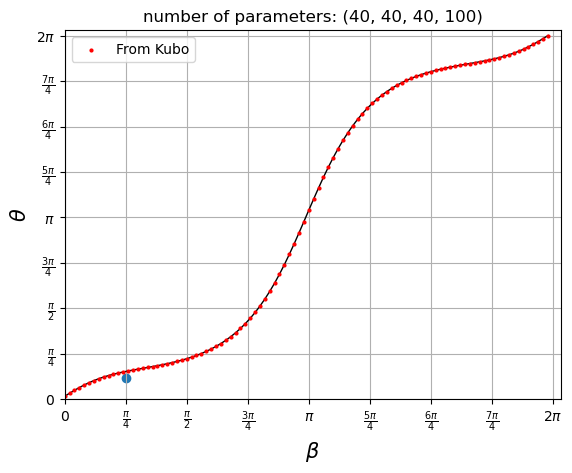

In [257]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

### Riemann sum
ax.plot(betas, thetas_kubo.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_kubo.real, s=4, zorder=2, c='r', label='From Kubo')

ax.scatter(beta, theta*5)

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.set_ylim(0, 2*np.pi+0.1)
ax.set_xlim(0, 2*np.pi+0.1) 

# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

ax.grid()
ax.legend()
ax.set_title(f"number of parameters: {n_param}")

# Starting Note Derivation

$|\partial_{\mu} u_{nk} \rangle$ from first order adiabatic

In [258]:
occ_idxs = np.arange(2)
cond_idxs = np.setdiff1d(np.arange(u_nk_flat.shape[-2]), occ_idxs)  # Identify conduction bands

In [259]:
parmu_u_occ = np.zeros((3, *u_occ_flat.shape), dtype=complex)
n_occ, n_con = u_occ_flat.shape[-2], u_con_flat.shape[-2]

for n in range(n_occ):
    for m in range(n_con):
        u_n_occ, u_m_con = u_occ_flat[..., n, :], u_con_flat[..., m, :]
        v_mu_mn = np.einsum("...j, ...jk, ...k", u_m_con.conj(), v_k, u_n_occ)
        T_mu_mn = v_mu_mn / (E_occ[..., n] - E_con[..., m])
        parmu_u_occ[..., n, :] += T_mu_mn[..., None] * u_m_con[None,...]

Get $\hat{v}_{\mu} \equiv \sum_{l \notin \rm occ} \frac{\langle u_{mk} | v_{\mu} | u_{lk} \rangle}{E_{mk} - E_{lk}}$

In [260]:
evecs_conj_tf = u_nk_flat.conj()
evecs_T_tf = u_nk_flat.swapaxes(-1,-2)  # (n_kpts, n_beta, n_state, n_state)

v_k_rot = np.matmul(
        evecs_conj_tf[None, ...],  # (1, n_kpts, n_state, n_state)
        np.matmul(
            v_k,                       # (dim_k, n_kpts, n_state, n_state)
            evecs_T_tf[None, ...]  # (1, n_kpts, n_beta, n_state, n_state)
        )
    ) 

print(v_k_rot.shape) 

(3, 50, 50, 50, 4, 4)


In [261]:
# Compute energy denominators
delta_E = E_nk[..., None, :] - E_nk[..., :, None]
delta_E_occ_cond = np.take(np.take(delta_E, occ_idxs, axis=-2), cond_idxs, axis=-1)
delta_E_cond_occ = np.take(np.take(delta_E, cond_idxs, axis=-2), occ_idxs, axis=-1)
inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond
inv_delta_E_cond_occ_tf = 1 / delta_E_cond_occ

In [262]:
v_occ_cond = np.take(np.take(v_k_rot, occ_idxs, axis=-2), cond_idxs, axis=-1)
v_cond_occ = np.take(np.take(v_k_rot, cond_idxs, axis=-2), occ_idxs, axis=-1)
v_occ_cond = v_occ_cond * -inv_delta_E_occ_cond_tf
v_cond_occ = v_cond_occ * -inv_delta_E_occ_cond_tf

vhat = v_occ_cond 

In [263]:
parmu_occ = np.sum(v_cond_occ, axis=-2)[..., None] * u_con_flat # sanity check

# NOTE: This term was not included in 1D derivation with orbitals at origin
orb_vecs = model.get_orb_vecs(Cartesian=False)
r_mu_twfs = 2*np.pi * (orb_vecs.T[:, None, :, None] * twfs).reshape(3, 2, 4)
rhat = np.einsum("...nj, amj -> a...nm", psi_occ_flat.conj(), r_mu_twfs)

parmu_S2 = vhat @ S_con 
parmu_S2 += 1j* berry_conn_occ @ S_occ
parmu_S2 += -1j * rhat

print(v_occ_cond.shape)
print(delta_E.shape)
print(S_con.shape)
print(parmu_S2.shape)
print(berry_conn_occ.shape)
# print(np.allclose(parmu_occ, parmu_occ))

(3, 50, 50, 50, 2, 2)
(50, 50, 50, 4, 4)
(50, 50, 50, 2, 2)
(3, 50, 50, 50, 2, 2)
(3, 50, 50, 50, 2, 2)


In [264]:
parmu_S = np.zeros((3, *S_con.shape), dtype=complex)
v_mu_occ_con = np.einsum("...mj, ...jk, ...nk", u_occ_flat.conj(), v_k, u_con_flat)

for n in range(S_occ.shape[-1]):
    for m in range(n_occ):
        for c in range(n_con):
            v_mu_mc = v_mu_occ_con[..., m, c]
            parmu_S[..., m, n] += ( v_mu_mc / (E_occ[None,..., m] - E_con[None,..., c]) ) * S_con[None, ..., c, n]

# NOTE: This term was missing previously
parmu_S += 1j* berry_conn_occ @ S_occ[None,...]

# NOTE: This term was missing previously
parmu_S += -1j* rhat
print(np.allclose(parmu_S, parmu_S2))

True


In [265]:
S_check = W.conj().swapaxes(-1,-2)[None,...] @ parmu_S2 @ Vh.conj().swapaxes(-1,-2)[None,...]

numerator = D[None, ..., :, None] * S_check + D[None, ..., None, :] * S_check.conj().swapaxes(-1,-2)
denominator = D[None, ..., :, None] + D[None, ..., None, :]
    
# Elementwise division
P_check = (numerator / denominator)
parmuP = Vh.conj().swapaxes(-1,-2) @ P_check @ Vh
PparmuP = P @ parmuP

# PparmuP = Vh @ (parmu_S.conj().swapaxes(-1,-2) @ S_occ + S_occ.conj().swapaxes(-1,-2) @ parmu_S) @ Vh.conj().swapaxes(-1,-2)
# for a in range(PparmuP.shape[-2]):
#     for b in range(PparmuP.shape[-1]):
#         PparmuP[..., a, b] *= (D[..., a] / (D[..., a] + D[..., b])) 

# PparmuP = Vh.conj().swapaxes(-1,-2) @ PparmuP @ Vh

In [266]:
UdagparU = np.linalg.inv(P) @ ( S_occ.conj().swapaxes(-1,-2) @ parmu_S - PparmuP ) @ np.linalg.inv(P)

print("Is U^dag dU anti-Hermitian?: ", np.amax(UdagparU.conj().swapaxes(-1,-2)+UdagparU == 0))

Is U^dag dU anti-Hermitian?:  True


Comparing $P\partial_{\mu}P$ from note and with finite difference. Since it is gauge-independent, this is smooth and well-defined with finite differences.

In [267]:
parx_P_fd = fin_diff(P, 0, 1/nks[0], 21)
pary_P_fd = fin_diff(P, 1, 1/nks[1], 21)
parz_P_fd = fin_diff(P, 2, 1/nks[2], 21)

P_parmuP_fd = np.array([parx_P_fd, pary_P_fd, parz_P_fd])

In [268]:
diff = (PparmuP - P_parmuP_fd)
max_diff_loc = np.where(diff==np.amax(diff))

print("nks:", nks)
print("Max abs(ParmuP_fd) abs:", np.amax(np.abs(P_parmuP_fd)))
print("Max difference abs:", np.amax(np.abs(diff)))
print("Max difference percent:", 100*np.amax(np.abs(diff))/np.amax(np.abs(P_parmuP_fd)))

nks: (50, 50, 50)
Max abs(ParmuP_fd) abs: 0.5507597702908784
Max difference abs: 0.0634764874375649
Max difference percent: 11.525258535865902


In [269]:
max_diff_loc

(array([0]), array([27]), array([25]), array([25]), array([1]), array([1]))

In [270]:
P_parmuP_fd[max_diff_loc[:-2]].round(5)

array([[[-0.42886+0.j,  0.     +0.j],
        [ 0.     +0.j, -0.42886-0.j]]])

In [271]:
PparmuP[max_diff_loc[:-2]].round(5)

array([[[-0.36538+0.j,  0.     +0.j],
        [ 0.     -0.j, -0.36538+0.j]]])

In [272]:
PparmuP[1][7,9,6].round(5)

array([[-0.09067+0.j,  0.     +0.j],
       [ 0.     -0.j, -0.09067+0.j]])

In [273]:
P_parmuP_fd[1][7,9,6].round(5)

array([[-0.09293+0.j,  0.     +0.j],
       [ 0.     +0.j, -0.09293-0.j]])

In [274]:
term =  S_occ.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat@ S_con)
term = Vh @ term @ Vh.conj().swapaxes(-1,-2)

for a in range(term.shape[-2]):
    for b in range(term.shape[-1]):
        term[..., a, b] *= (1 / (D[..., a] + D[..., b]))

term = Vh.conj().swapaxes(-1,-2) @ term @ Vh
term  = term - term.conj().swapaxes(-1,-2)

A_til = (
    U_SVD.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat @ S_con)
    - term
) @ np.linalg.inv(P) 

In [275]:
diff_A = (berry_conn_tilde - A_til)
max_diff_loc = np.where(diff_A==np.amax(diff_A))

print("nks:", nks)
print("Max abs(tilde A):", np.amax(np.abs(berry_conn_tilde)))
print("Max difference abs:", np.amax(np.abs(diff_A)))
print("Max difference percent:", 100*np.amax(np.abs(diff_A))/np.amax(np.abs(berry_conn_tilde)))

nks: (50, 50, 50)
Max abs(tilde A): 5.463328151977989
Max difference abs: 0.48796620334208685
Max difference percent: 8.931665639842986


In [279]:
numerator = np.sum(np.abs(diff_A)**2)
denominator = np.sum(np.abs(A_til)**2)
relative_error_percent =  np.sqrt(numerator / denominator)

In [280]:
relative_error_percent

np.float64(0.03458460864227679)

In [278]:
berry_conn_tilde[max_diff_loc[:-2]].round(5)

array([[[ 4.72266+0.j     ,  0.17028-0.53896j],
        [ 0.17028+0.53896j, -3.15187-0.j     ]]])

In [209]:
A_til[max_diff_loc[:-2]].round(5)

array([[[ 8.07696412e+15+2.70837000e+00j,
         -1.26907081e+16-3.86256252e+15j],
        [-1.26907081e+16+3.86256252e+15j,
         -8.43570737e+15-3.70311000e+00j]]])

In [210]:
parx_A[0][-6,0,0]

array([[ 1.36299465e-10-8.62398780e-15j, -1.79256533e-14+2.84657165e-14j],
       [-3.50834142e-15-1.54971276e-14j,  1.36325035e-10+8.74949218e-15j]])

In [211]:
abs_diff_A = np.linalg.norm(diff_A, axis=(-1,-2))
norm_diff_A = abs_diff_A/np.linalg.norm(A_til, axis=(-1,-2))

images/Berry_conn_diff_note_nks=(50, 50, 50)_beta=3.14.png


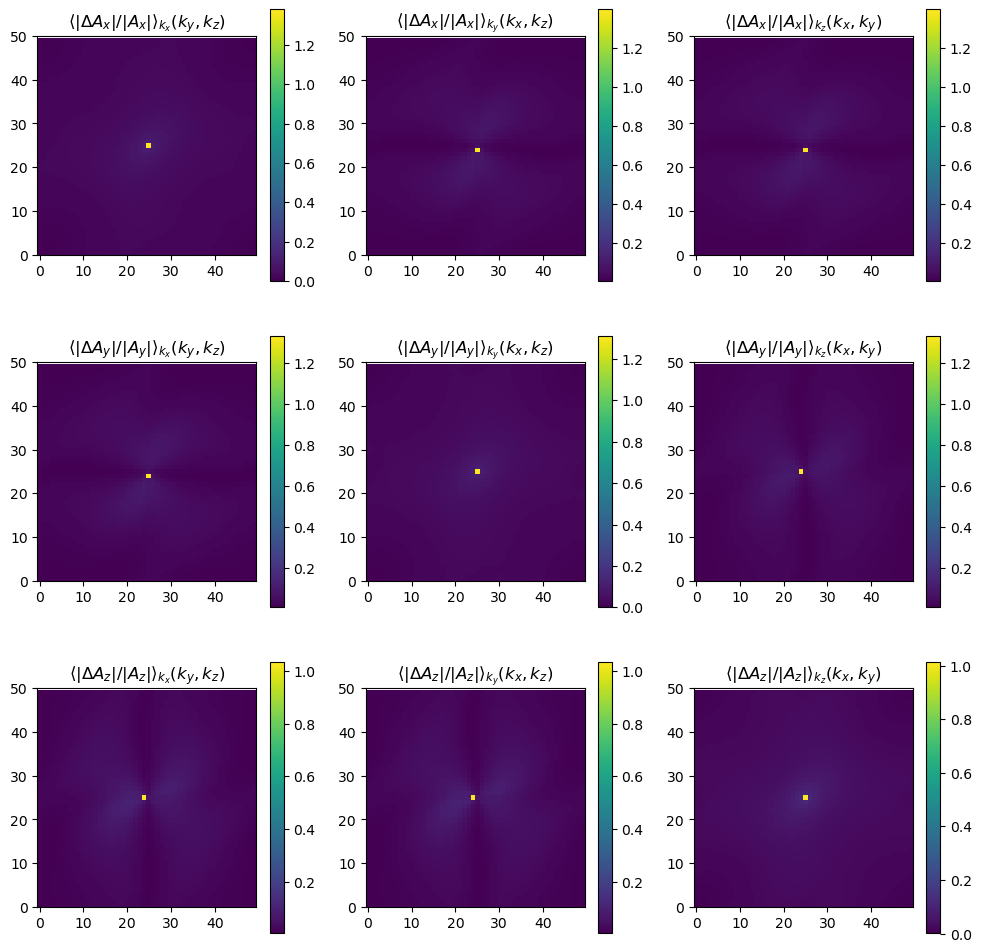

In [212]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))

avg_x = np.sum(norm_diff_A, axis=1)/diff_A.shape[1]
avg_y = np.sum(norm_diff_A, axis=2)/diff_A.shape[2]
avg_z = np.sum(norm_diff_A, axis=3)/diff_A.shape[3]

plots = []
im = axs[0,0].imshow(avg_x[0])
axs[0,0].set_title(r"$ \langle |\Delta A_x|/|A_x| \rangle_{k_x}(k_y,k_z)$")
plots.append(im)
im = axs[0,1].imshow(avg_y[0])
axs[0,1].set_title(r"$ \langle |\Delta A_x|/|A_x| \rangle_{k_y}(k_x,k_z)$")
plots.append(im)
im = axs[0,2].imshow(avg_z[0])
axs[0,2].set_title(r"$ \langle |\Delta A_x|/|A_x| \rangle_{k_z}(k_x,k_y)$")
plots.append(im)
im = axs[1,0].imshow(avg_x[1])
axs[1,0].set_title(r"$ \langle |\Delta A_y|/|A_y| \rangle_{k_x}(k_y,k_z)$")
plots.append(im)
im = axs[1,1].imshow(avg_y[1])
axs[1,1].set_title(r"$ \langle |\Delta A_y|/|A_y| \rangle_{k_y}(k_x,k_z)$")
plots.append(im)
im = axs[1,2].imshow(avg_z[1])
axs[1,2].set_title(r"$ \langle |\Delta A_y|/|A_y| \rangle_{k_z}(k_x,k_y)$")
plots.append(im)
im = axs[2,0].imshow(avg_x[2])
axs[2,0].set_title(r"$ \langle |\Delta A_z|/|A_z| \rangle_{k_x}(k_y,k_z)$")
plots.append(im)
im = axs[2,1].imshow(avg_y[2])
axs[2,1].set_title(r"$ \langle |\Delta A_z|/|A_z| \rangle_{k_y}(k_x,k_z)$")
plots.append(im)
im = axs[2,2].imshow(avg_z[2])
axs[2,2].set_title(r"$ \langle |\Delta A_z|/|A_z| \rangle_{k_z}(k_x,k_y)$")
plots.append(im)

for im in plots:
    plt.colorbar(im)

for row in axs:
    for col in row:
        col.set_ylim(0, nks[0])

# plt.title('hey')

save_name = f'images/Berry_conn_diff_note_nks={nks}_beta={beta:.2f}.png'
print(save_name)
plt.savefig(save_name)

In [213]:
A_til.shape

(3, 50, 50, 50, 2, 2)

In [214]:
parx_A = fin_diff(A_til, mu=1, dk_mu=dks[0], order_eps=12)
pary_A = fin_diff(A_til, mu=2, dk_mu=dks[1], order_eps=12)
parz_A = fin_diff(A_til, mu=3, dk_mu=dks[2], order_eps=12)

par_A = np.array([parx_A, pary_A, parz_A])

In [215]:
epsilon = levi_civita(3,3)

AdA = np.einsum("i...ab, jk...ba -> ijk...", A_til, par_A)
AAA = np.einsum("i...ab, j...bc, k...ca -> ijk...", A_til, A_til, A_til)
integrand = np.einsum("ijk, ijk... -> ...", epsilon, AdA - (2j/3) * AAA)

theta = -(4*np.pi)**(-1) * np.sum(integrand) * np.prod(dks)
theta

np.complex128(-6.474633088635315e+42-2.737382792807868e+27j)

In [216]:
# term1 = np.einsum("i...nm, jk...mo -> ijk...no", A_til, omega_kubo)
# term2 = -(1j/3) * np.einsum("i...ab, j...bc, k...cd -> ijk...ad", A_til, A_til, A_til)
# brackets = term1 + term2
# trace = np.trace(brackets, axis1=-1, axis2=-2)
# eps = np.einsum("ijk, ijk... -> ...", epsilon, trace)

# theta = -(4*np.pi)**(-1) * np.sum(eps) * (1/np.prod(nks))
# theta

In [217]:
# np.where(omega_kubo == np.amax(omega_kubo))

In [218]:
# np.amax(term1)

In [219]:
# np.amax(term2)

In [220]:
# brackets = np.einsum("ijk, i...nm, jk...mn -> ...", epsilon, A_til, omega_tilde)
# brackets -= (1j/3) * np.einsum("ijk, i...ab, j...bc, k...ca -> ...", epsilon, A_til, A_til, A_til)

# theta = -(4*np.pi)**(-1) * np.sum(brackets) * (1/np.prod(nks))
# theta

/Users/treycole/miniforge3/envs/axion/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, 'number of parameters: (40, 40, 40, 100)')

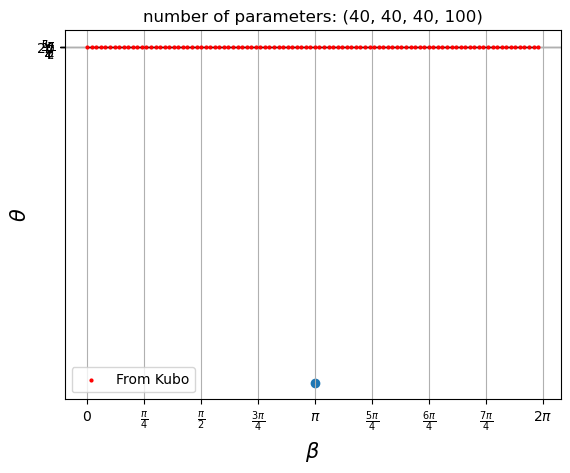

In [221]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

### Riemann sum
ax.plot(betas, thetas_kubo.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_kubo.real, s=4, zorder=2, c='r', label='From Kubo')
ax.scatter(beta, theta)

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# ax.set_ylim(0, 2*np.pi+0.1)
# ax.set_xlim(0, 2*np.pi+0.1) 

# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

ax.grid()
ax.legend()
ax.set_title(f"number of parameters: {n_param}")